In [2]:
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import data_manager as dm
import sys
%matplotlib inline

In [77]:
with open('C:\\ASM\\DevData\\eating\\meal_detection\\data\\steven_free_data.pkl', 'rb') as file:
    data = pickle.load(file)

In [104]:
def get_clusters(mps, res, min_bite_interval):    
    mps = mps[:, 0].reshape((len(mps), 1))
    res = res[:, 1].reshape((len(res), 1))
    res = np.concatenate((mps, res), axis=1)
    res = res[res[:,1]==1, :]    
    
    clusters = []
    min_bite_interval = params['max_bite_interval']
    
    s = 0    
    for i in range(1, len(res)):                
        if res[i, 0] - res[i-1, 0] > min_bite_interval:
            st = res[s, 0]
            et = res[i-1, 0]
            bite_count = i-s
            clusters.append([st, et, bite_count])
            s = i
            
    st = res[s, 0]
    et = res[-1, 0]
    bite_count = i-s
    clusters.append([st, et, bite_count])    
    clusters = np.array(clusters)
    return clusters

def detect_meals(mps, res, params):
    c = get_clusters(mps, res, params["max_bite_interval"])    
    if len(c)==0:
        return []
    
    c = c[c[:, 2]>=3, :]
    if len(c)==0:
        return []
    
    meals = []
    s = 0
    for i in range(1, len(c)):
            if c[i, 0] - c[i-1, 1] > params["min_cluster_interval"]:
                st = c[s, 0]
                et = c[i-1, 1]
                meals.append([st, et])
                s = i
                
    st = c[s, 0]
    et = c[-1, 1]
    meals.append([st, et])
    meals = np.array(meals)
    return meals
 

In [113]:
def analyze_result_individual_sess(annots, mps, res, params):    
    if len(mps) != len(res):
        print("Lengths of mps and res are not same")
        sys.exit(0)
    
    #print(annots)    
    meals = detect_meals(mps, res, params)
    
    tp = [0, 0, 0]
    fn = [0, 0, 0]
    fp = 0
    
    for i in range(len(annots)):        
        meal_type = int(annots[i, 2])
        meal_detected = False
        for j in range(len(meals)):             
            if annots[i, 0]<= meals[j, 0]<= annots[i, 1] or annots[i, 0]<= meals[j, 1]<= annots[i, 1] or meals[j, 0]<=annots[i,0]<=annots[i, 1]<=meals[j,1]:                
                meal_detected = True
                break
        
        if meal_detected == True:
            tp[meal_type-1] = tp[meal_type-1] + 1
        else:
            fn[meal_type-1] = fn[meal_type-1] + 1
    
    for i in range(len(meals)):
        meal_detected = False
        #print(meals[i, :])        
        for j in range(len(annots)):            
            #print('%d, %d'%(annots[j, 0], annots[j, 1]) )
            if meals[i, 0] <= annots[j, 0]<= meals[i, 1] or meals[i, 0]<= annots[j, 1]<= meals[i, 1] or annots[j, 0]<=meals[i,0]<=meals[i, 1]<=annots[j,1]:                
                meal_detected = True
                #print("Meal detected")
                break
        
        if meal_detected == False:
            #print("Meal detected False")
            fp = fp + 1
    
    res = tp
    res.extend(fn)
    res.extend([fp, len(meals)])
    #print(annots)
    #print(meals)
    #print(res)\
    
    tp = [0, 0, 0]
    total = [0, 0, 0]
    fp = 0
    
    for i in range(len(annots)):
        aleft = annots[i, 0]
        aright = annots[i, 1]        
        meal_type = int(annots[i, 2])
        total[meal_type-1] = total[meal_type-1] + (aright-aleft)
        
        for j in range(len(meals)):            
            mleft = meals[j, 0]
            mright = meals[j, 1]
            
            if mleft >= aright:
                break
                
            if mright < aleft:
                continue            
            
            if aleft <= mleft <= mright <= aright:                
                tp[meal_type-1] = tp[meal_type-1] + (mright - mleft)
                
            elif mleft <= aleft <= aright <= mright:
                tp[meal_type-1] = tp[meal_type-1] + (aright - aleft)
                
            elif mleft <= aleft <= mright <= aright:
                tp[meal_type-1] = tp[meal_type-1] + (mright - aleft)
            
            elif aleft <= mleft <= aright <= mright:
                tp[meal_type-1] = tp[meal_type-1] + (aright - mleft)
            else:
                print("Condition doesn't match")
                sys.exit(0)
                
    fn = [0, 0, 0]    
    fn[0] = total[0] - tp[0]
    fn[1] = total[1] - tp[1]
    fn[2] = total[2] - tp[2]
    
    fp = 0
    for i in range(len(meals)):
        mleft = meals[i, 0]
        mright = meals[i, 1]        
        fp = fp + mright - mleft
        
        for j in range(len(annots)):            
            aleft = annots[j, 0]
            aright = annots[j, 1]
            
            if aleft >= mright:
                break
                
            if aright < mleft:
                continue            
            
            if aleft <= mleft <= mright <= aright:                
                fp = fp - (mright - mleft)
                
            elif mleft <= aleft <= aright <= mright:
                fp = fp - (aright - aleft)
                
            elif mleft <= aleft <= mright <= aright:
                fp = fp - (mright - aleft)
            
            elif aleft <= mleft <= aright <= mright:
                fp = fp - (aright - mleft)
                
            else:
                print("Condition doesn't match")
                sys.exit(0)
       
    res.extend(tp)
    res.extend(fn)
    res.extend([fp])
    
    return res

In [117]:
def analyze_result_all_subjects(win_size, xth, data, mps_all, res_all, params):
    subject_count = len(data)
    
    output = np.empty((0, 19))
    for subject in range(subject_count):
        for sess in range(len(res_all[subject]["free"])):
            #print("Subject, Sess::", subject, sess)
            annots = data[subject][sess][1]
            res = res_all[subject]["free"][sess]
            mps = mps_all[3][subject][sess]
            
            r = [win_size, xth, subject, sess]
            rs = analyze_result_individual_sess(annots, mps, res, params)            
            r.extend(rs)            
            r = np.array(r).reshape((1, len(r)))
            output = np.concatenate((output, r))
            
    return output

In [138]:
res = np.empty((0, 19))
params = {}
params['max_bite_interval'] = 60*16
params["min_cluster_interval"] = 5*60*16
params["min_cluster_bite_count"] = 3

for win_size in range(32, 65, 8):
    for xth in range(10, 41, 5):
        folder = 'len_{}_{}_xth_{}_smooth_800'.format(win_size, win_size, xth)        
        path = 'C:\\ASM\\DevData\\eating\\meal_detection\\results\\' + folder +"\\"
        with open(path+"mps.pkl", "rb") as file:
            mps_all = pickle.load(file)
        with open(path+"results\\res_all.pkl", "rb") as file:
            res_all = pickle.load(file)           
        
        #print(folder)
        r = analyze_result_all_subjects(win_size, xth, data, mps_all, res_all, params)        
        res = np.concatenate((res, r))
        
print(len(res))

875


In [137]:
#res = res[(res[:,0]==64) & (res[:, 1]==30), :]
#print(res)

[[6.40000e+01 3.00000e+01 0.00000e+00 0.00000e+00 2.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 1.00000e+00 5.00000e+00
  7.41000e+03 0.00000e+00 0.00000e+00 2.62740e+04 0.00000e+00 9.44000e+02
  8.66000e+02]
 [6.40000e+01 3.00000e+01 0.00000e+00 1.00000e+00 2.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 3.00000e+00 0.00000e+00 2.00000e+00
  9.45000e+03 0.00000e+00 0.00000e+00 1.24650e+04 0.00000e+00 2.59700e+03
  0.00000e+00]
 [6.40000e+01 3.00000e+01 1.00000e+00 0.00000e+00 3.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 2.00000e+00 0.00000e+00 0.00000e+00 7.00000e+00
  2.48430e+04 0.00000e+00 0.00000e+00 5.21710e+04 1.64700e+03 0.00000e+00
  0.00000e+00]
 [6.40000e+01 3.00000e+01 1.00000e+00 1.00000e+00 2.00000e+00 1.00000e+00
  0.00000e+00 1.00000e+00 2.00000e+00 1.00000e+00 0.00000e+00 4.00000e+00
  2.03300e+04 2.12100e+03 0.00000e+00 2.72760e+04 1.05010e+04 5.70970e+04
  0.00000e+00]
 [6.40000e+01 3.00000e+01 2.00000e+00 0.00000e+00 3.

In [72]:
rs = np.empty((0, 6))
for win_size in range(32, 65, 8):        
    for xth in range(10, 41, 5):
        r = res[(res[:,0]==win_size) & (res[:,1]==xth), 4:]                
        r = np.sum(r, axis=0)                
        r = [win_size, xth, r[0], r[1], r[2], r[3]]
        r = np.array(r).reshape((1, len(r)))        
        rs = np.concatenate((rs, r))
#print(rs)

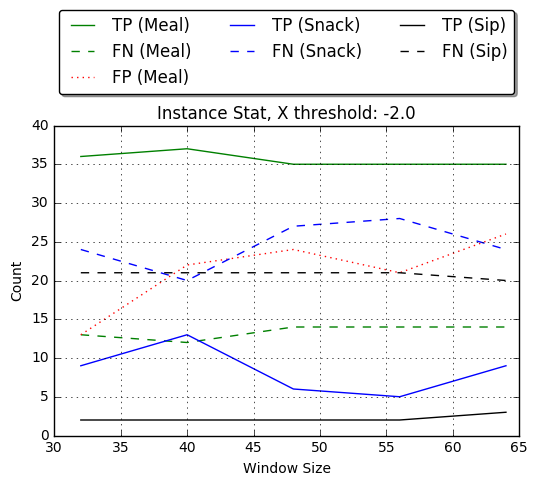

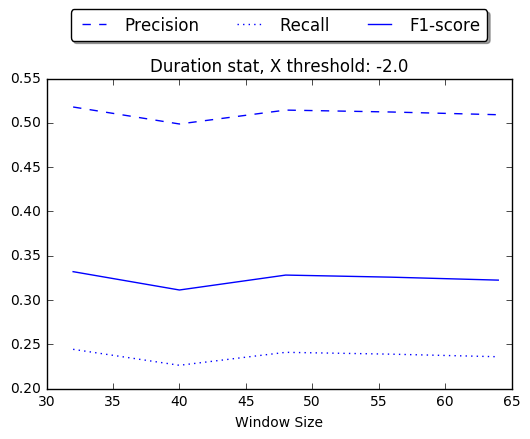

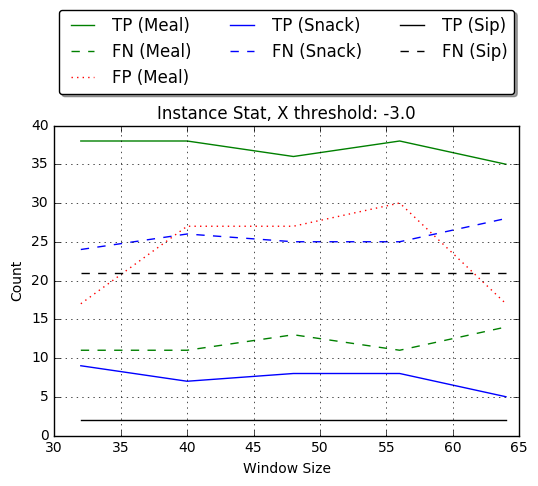

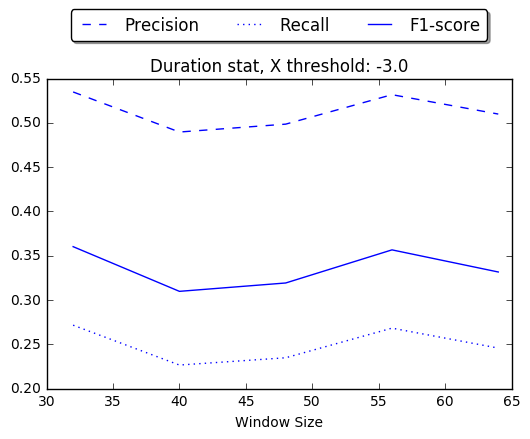

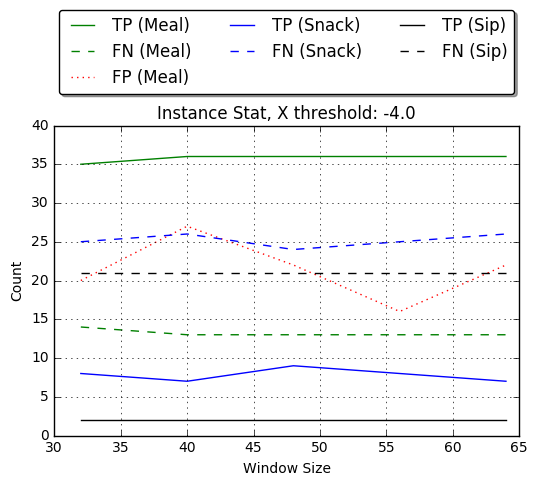

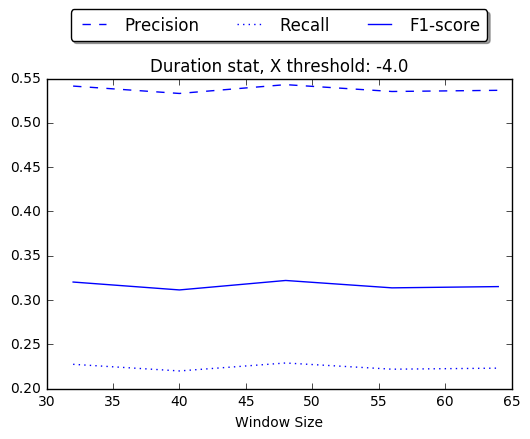

In [147]:
for xth in [20, 30, 40]:
    all_r = []
    for win_size in range(32, 65, 8):
        r = res[(res[:,0]==win_size) & (res[:, 1]==xth), :]
        r = np.sum(r[:, 3:], axis = 0)
        r = r.reshape((1, len(r)))
        r[0, 0] = win_size

        if len(all_r)==0:
            all_r = r
        else:
            all_r = np.concatenate([all_r, r])
    
    #print(all_r)
    fig = plt.figure()
    ax = plt.subplot(111)

    ax.plot(all_r[:, 0], all_r[:,1], color='green', label='TP (Meal)')
    ax.plot(all_r[:, 0], all_r[:,4], linestyle='--', color='green', label='FN (Meal)')
    ax.plot(all_r[:, 0], all_r[:,7], linestyle=':', color='red', label='FP (Meal)')    
    
    ax.plot(all_r[:, 0], all_r[:,2], color='blue', label='TP (Snack)')    
    ax.plot(all_r[:, 0], all_r[:,5], linestyle='--', color='blue', label='FN (Snack)')
    
    ax.plot(all_r[:, 0], all_r[:,3], color='black', label='TP (Sip)')
    ax.plot(all_r[:, 0], all_r[:,6], linestyle='--', color='black', label='FN (Sip)')
    
    plt.xlabel('Window Size')
    plt.ylabel('Count')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.40), ncol=3, fancybox=True, shadow=True)
    plt.title('Instance Stat, X threshold: '+str(-xth/10))
    plt.grid(True)
    plt.show()
            
    fig = plt.figure()
    ax = plt.subplot(111)
    tp = np.sum(all_r[:, 9:12], axis=1)
    fn = np.sum(all_r[:, 12:15], axis=1)
    fp = np.sum(all_r[:, 15])
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*precision*recall/(precision+recall)
    
    ax.plot(all_r[:, 0], precision, linestyle='--', color='blue', label='Precision')
    ax.plot(all_r[:, 0], recall, linestyle=':', color='blue', label='Recall')
    ax.plot(all_r[:, 0], f1, linestyle='-', color='blue', label='F1-score')    
    
    plt.xlabel('Window Size')    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, fancybox=True, shadow=True)
    plt.title('Duration stat, X threshold: '+str(-xth/10))
    
    plt.show()
    
    """
    all_r[:, 8:] = all_r[:, 8:]/(16*60)    
    fig = plt.figure()
    ax = plt.subplot(111)

    ax.plot(all_r[:, 0], all_r[:, 9], color='green', label='TP (Meal)')
    ax.plot(all_r[:, 0], all_r[:,12], linestyle='--', color='green', label='FN (Meal)')
    ax.plot(all_r[:, 0], all_r[:,15], linestyle=':', color='red', label='FP (Meal)')    
    
    ax.plot(all_r[:, 0], all_r[:,10], color='blue', label='TP (Snack)')    
    ax.plot(all_r[:, 0], all_r[:,13], linestyle='--', color='blue', label='FN (Snack)')
    
    ax.plot(all_r[:, 0], all_r[:,11], color='black', label='TP (Sip)')
    ax.plot(all_r[:, 0], all_r[:,14], linestyle='--', color='black', label='FN (Sip)')
    
    
    
    plt.xlabel('Window Size')
    plt.ylabel('Duration')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.40), ncol=3, fancybox=True, shadow=True)
    plt.title('Duration stat, X threshold: '+str(xth))
    
    plt.show()
    """
    
    
        
        


    
